## clip部分井段，绘制GNN和BiLSTM效果，加MSE评价指标

In [117]:
import time
import torch
import random
import numpy as np
import torch_geometric as tg
import os
import pandas as pd
import argparse
import torch_geometric.loader as loader
from matplotlib import pyplot as plt

from utils.utils import *
from utils.load_data import *
from utils.model import *
from utils.plot_cat_sam import *
from utils.gardner import *
from utils.my_corr_eva import *
from utils.paper_fig import *

#np.random.seed(19680801)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [118]:
!pwd  #查看所在的文件夹
%load_ext autoreload
%autoreload 2

'''这两句的意思是当你导入了自己写的python模块时，在ipynb文件里import一次之后，即使你修改了你的python模块，重新运行import其实还是用的之前的python模块
（因为已经将该模块在第一次导入时存在了内存里，第二次import没效果），这时需要重启kenel才能导入修改过的python模块。
上面这两条语句是自动加载你导入的python模块，保证你每次在ipynb里使用的模块是最新版本，所以在你修改了模块代码之后，不需要重新刷新你的kenel。

%autoreload 0：禁用自动重新加载。这是默认设置。

%autoreload 1 : 只会自动重新加载使用 %aimport 函数导入的模块（例如 %aimport my_module）。如果您只想专门自动重新加载选定的模块，这是一个不错的选择。

%autoreload 2：自动重新加载所有模块。使编写和测试模块变得更加容易的好方法。'''

/home/cldai/sciresearch/logcomplete
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'这两句的意思是当你导入了自己写的python模块时，在ipynb文件里import一次之后，即使你修改了你的python模块，重新运行import其实还是用的之前的python模块\n（因为已经将该模块在第一次导入时存在了内存里，第二次import没效果），这时需要重启kenel才能导入修改过的python模块。\n上面这两条语句是自动加载你导入的python模块，保证你每次在ipynb里使用的模块是最新版本，所以在你修改了模块代码之后，不需要重新刷新你的kenel。\n\n%autoreload 0：禁用自动重新加载。这是默认设置。\n\n%autoreload 1 : 只会自动重新加载使用 %aimport 函数导入的模块（例如 %aimport my_module）。如果您只想专门自动重新加载选定的模块，这是一个不错的选择。\n\n%autoreload 2：自动重新加载所有模块。使编写和测试模块变得更加容易的好方法。'

In [119]:
#jupyter 不运行argparser，把argparser改写成Param的字典形式就好，  ""
param = {}
param['save_model_path'] = '/home/cldai/sciresearch/logcomplete/model/model_save/'   #"模型存放的路径"
param['model_name'] = 'xyz_1500_2.2exp1.pt'  

param['filePath'] = '/home/cldai/sciresearch/logcomplete/data/Teamdata/standard_wells/data2/'  #file path of train and test

param['dataset_for_result'] = 'test'  #'test:用测试集; val:用验证集; train:用训练集看效果'
param['label_intact'] = True  ##现在要用MyGNNDataset_cat_sam，所以label_intact无论什么数据都=True没关系

param['mask_logs'] = ['DTC']  #人为事先mask掉的logs
param['plot_Gardner'] = True
param['sam_fixed'] = True  #样本‘选择性‘固定  #class MyGNNDataset_cat_sam(gdata.Dataset)中所需

param['all_mean'] = np.array([71.38444259, 2.28596682, 0.33244899, 113.28539098])
param['all_std'] = np.array([22.58998274, 0.21672449, 0.10531198, 27.63277418])
# param['all_mean'] = np.array([0, 0, 0, 0])
# param['all_std'] = np.array([1, 1, 1, 1])


param['multi_ch'] = True  #根据输入数据是否为多通道数据决定，影响后面plot的数据选择
param['data_norm_type'] = ''  #数据归一化的类型,按样本(sample)每个分别归一化或者按每口井(well)归一化
param['graph_channels'] = [512,256,128,64,32]  #"Channels of graphunet in each layers"
param['sam_len'] = 512  #length of every sample

param['null_sequence'] = True  #True对应某整个序列赋为空值,否则序列的部分片段赋为空值

param['reverse_norm'] = True  #是否要进行反归一化
param['fea_litho'] = ['GR', 'RHOB', 'NPHI', 'DTC']  #feature and lithology that we need

param['fig_path'] = '/home/cldai/sciresearch/logcomplete/figure/'  #the figure to save 
param['plot_figure'] = True  #If plot figure for test

param['filt_size'] = 19  #中值滤波的窗口大小，只可为奇数   #original=7
param['drop'] = 0  #网络的dropout
param['head'] = 1
param['pnl'] = False  #pnl:pred(need)_label。true：第三张图画pred_need_label，即需要预测的和label，False:画整条预测和label
param['has_w'] = False  #w可视化，看有没有输出要可视化
param['batch_size'] = 1  #batch size
param['sam_num'] = 1  #the number of sample in every set

## 加载模型和模型参数
* 1

In [120]:
# def check_input_label(input,label,label_intact):
#     print('test_muti_sam中检查原input和label是否一致')
#     fig =plt.figure(figsize=(12,5),dpi=300)  #(width,height)
#     y = [i for i in range(512)]
#     data = [input,label,label_intact]
#     legend=['input','label','label_intact']
#     count=1
#     for fea in range(4):
#         ax1 = fig.add_subplot(1,4,count)
#         #for item in range(len(data)):
#         for item in range(3):
#             ax1.plot(data[item][fea,:],y,label=legend[item])
#         plt.legend(loc='upper right')
#         count +=1
    
#     plt.tight_layout()
#     plt.savefig('/home/cldai/sciresearch/logcomplete/figure/loda_data_check/input_label/input_label(最终图前).png')

## 加载数据

In [121]:
if param['dataset_for_result'] == 'val':
    print('用 验证集 数据看效果')
    dfval=pd.read_csv(param['filePath'] +'val_standard.csv',engine='python')
    
    all_well_name=dfval['WELL'].unique() 
    all_well_name_r= all_well_name
    print('all_well_name_r',all_well_name_r)
    
    #取出井看每一口井的长度
    all_well_len = dfval.groupby('WELL', sort=False).size()
    print('all_well_len',all_well_len)  #all_well_len is Series
    num_siw = np.array(all_well_len/param['sam_len'],dtype=int)  #num_siw is num_sam_in_well
    print('每口井中样本的个数',num_siw)
    
elif param['dataset_for_result'] == 'train':
    print('用 训练集 数据看效果')
    dfTrain=pd.read_csv(param['filePath'] +'train_standard.csv',engine='python')
    
    all_well_name=dfTrain['WELL'].unique() 
    all_well_name_r= all_well_name
    print('all_well_name_r',all_well_name_r)
    
    all_well_name_r=[]
    for i in range(len(all_well_name)):
        r = all_well_name[i].replace('/','-') 
        all_well_name_r .append(r)
    print('all_well_name',all_well_name)  
    print('all_well_name_r',all_well_name_r)
    
    #取出井看每一口井的长度
    #sort=False使groupby不按index排序，避免改变原index顺序
    all_well_len = dfTrain.groupby('WELL', sort=False).size()
    print('all_well_len',all_well_len)  #all_well_len is Series
    num_siw = np.array(all_well_len/param['sam_len'],dtype=int)  #num_siw is num_sam_in_well
    print('每口井中样本的个数',num_siw)
    
else:
    print('用 测试集 数据看效果')
    print('缺失的feature为：',param['mask_logs'])  
    dfTest=pd.read_csv(param['filePath'] +'test_standard.csv',engine='python')   ##

    all_well_name=dfTest['WELL'].unique() 
    all_well_name_r= all_well_name
    
    all_well_name_r=[]
    for i in range(len(all_well_name)):
        r = all_well_name[i].replace('/','-') 
        all_well_name_r .append(r)
    print('all_well_name',all_well_name)  
    print('all_well_name_r',all_well_name_r)
    
    #取出井看每一口井的长度
    all_well_len = dfTest.groupby('WELL', sort=False).size()
    print('all_well_len',all_well_len)  #all_well_len is Series
    num_siw = np.array(all_well_len/param['sam_len'],dtype=int)  #num_siw is num_sam_in_well
    print('每口井中样本的个数',num_siw)
    



用 测试集 数据看效果
缺失的feature为： ['DTC']
all_well_name ['15/9-23' '16/2-7' '16/7-6' '17/4-1' '25/10-9' '31/2-10' '31/2-21 S'
 '34/3-2 S' '35/11-5' '35/9-7']
all_well_name_r ['15-9-23', '16-2-7', '16-7-6', '17-4-1', '25-10-9', '31-2-10', '31-2-21 S', '34-3-2 S', '35-11-5', '35-9-7']
all_well_len WELL
15/9-23      11063
16/2-7       11683
16/7-6       10222
17/4-1       17271
25/10-9      10788
31/2-10       9033
31/2-21 S     7840
34/3-2 S     12216
35/11-5      21604
35/9-7       10677
dtype: int64
每口井中样本的个数 [21 22 19 33 21 17 15 23 42 20]


In [122]:
def prediction_label_input(test_loader_n):
        predictions = []
        labels = []
        inputdatas = []
        mask0s = []
        maskds = []
        label_intacts = []
        md_staps = []
        md_endps = []
        # norm_means = []
        # norm_stds = []

        
        #print('len(test_loader_n)',len(test_loader_n))
        for data in test_loader_n:
            inputdata = data.x.detach().cpu().numpy()
            
            if param['has_w'] == True:
                pred, _ = model(data)
                pred = pred.detach().cpu().numpy() 
            else:
                pred, mean, std =  model(data)
            
            pred = pred.detach().cpu().numpy()
            label = data.y.detach().cpu().numpy()
            mask0 = data.mask.detach().cpu().numpy()
            maskd = data.maskd.detach().cpu().numpy()
            md_stap = data.md_stap.detach().cpu().numpy()
            md_endp = data.md_endp.detach().cpu().numpy()
            mean = mean.detach().cpu().numpy()
            std = std.detach().cpu().numpy()
            mean = np.reshape(mean,(4,1))
            std = np.reshape(std,(4,1))
            
            label_mean = data.norm_mean.detach().cpu().numpy()
            label_std = data.norm_std.detach().cpu().numpy()
            
            if param['label_intact']==True:
                label_intact = data.label_intact.detach().cpu().numpy()
                label_intact = label_intact *np.reshape(param['all_std'],(4,1)) + np.reshape(
                                param['all_mean'],(4,1))

            #print('mean.shape',mean.shape)
            pred = pred*std+mean
            #print('反归一化后pred.shape',pred.shape)
            pred = pred*np.reshape(param['all_std'],(4,1)) + np.reshape(param['all_mean'],(4,1))
            #print('按全井反归一化后pred.shape', pred.shape)
            
            inputdata = inputdata*np.reshape(label_std,(4,1,1))+ np.reshape(label_mean,(4,1,1))
            #print('反归一化后inputdata.shape',inputdata.shape)
            inputdata = inputdata*np.reshape(param['all_std'],(4,1,1))+ np.reshape(
                        param['all_mean'],(4,1,1))
            
            label = label*np.reshape(label_std, (4,1))+np.reshape(label_mean, (4,1))
            label = label*np.reshape(param['all_std'],(4,1)) + np.reshape(param['all_mean'],(4,1))
            
            
            predictions.append(pred)  #将numpy数组append进list里，pred:[array[[64长度]...[] (7*64)] ]
            labels.append(label)
            inputdatas.append(inputdata)
            mask0s.append(mask0)
            maskds.append(maskd)
            md_staps.append(md_stap)
            md_endps.append(md_endp)
            # norm_means.append(norm_mean)
            # norm_stds.append(norm_std)
            
            if param['label_intact']==True:
                label_intacts.append(label_intact)

        predictions=np.array(predictions)  #shape[[[]]]  #shape:(sam_num/batch_size, 7*batch_size, 64)
        labels=np.array(labels)
        inputdatas=np.array(inputdatas)
        mask0s=np.array(mask0s)
        maskds=np.array(maskds)
        md_staps = np.array(md_staps)
        md_endps = np.array(md_endps)


        if param['label_intact']==True:
            label_intacts= np.array(label_intacts)
            return predictions, labels, inputdatas, mask0s, maskds, label_intacts,  md_staps,md_endps
        else:    
            return predictions, labels, inputdatas, mask0s, maskds, md_staps,md_endps,


In [123]:
#加载模型
model = GraphNet(param['graph_channels'],param['batch_size'],param['fea_litho'],param['head'],param['drop'])
load_model_name_phase = param['save_model_path'] +param['model_name'] 
'''torch.load加载模型，map_location=cpu,Load all tensors onto the CPU. 加上了['net']，则仅加载了net,save_model时中其他的参数没加载'''
param_model = torch.load(load_model_name_phase,map_location='cpu')['net']  
#param_model = torch.load(load_model_name_phase)['net']
#model.load_state_dict(param_model)  #加载模型参数
model.load_state_dict({k.replace('module.',''):v for k,v in param_model.items()})

！！！！！！！！！！！注意 不聚合的网络中device： cpu
！！！！！！！！！！！注意 不聚合的网络中device： cpu
！！！！！！！！！！！注意 不聚合的网络中device： cpu
！！！！！！！！！！！注意 不聚合的网络中device： cpu
！！！！！！！！！！！注意网络中device： cpu
！！！！！！！！！！！注意网络中device： cpu
！！！！！！！！！！！注意网络中device： cpu
！！！！！！！！！！！注意网络中device： cpu


<All keys matched successfully>

## 预测训练集或验证集的井

掩盖的log类型是： ['DTC']


选取的起始点： 0
选取的起始点： 512
选取的起始点： 1024
选取的起始点： 1536
选取的起始点： 2048
选取的起始点： 2560
选取的起始点： 3072
选取的起始点： 3584
选取的起始点： 4096
选取的起始点： 4608
选取的起始点： 5120
选取的起始点： 5632
选取的起始点： 6144
选取的起始点： 6656
选取的起始点： 7168
选取的起始点： 7680
选取的起始点： 8192
选取的起始点： 8704
选取的起始点： 9216
画16-7-6井
len(lis) 4
df_dtc.shape (9728, 2)
下面看去除nan值后的相关系数和交汇图
dtc_dna.shape (9728, 2)
检验标签log中是否有nan False
计算bilstm预测数据的MSE，预测数据的shape为 (1, 9728)
检验标签log中是否有nan False
df_lp.shape,(len,2) (9728, 2)
选取的起始点： 0
选取的起始点： 512
选取的起始点： 1024
选取的起始点： 1536
选取的起始点： 2048
选取的起始点： 2560
选取的起始点： 3072
选取的起始点： 3584
选取的起始点： 4096
选取的起始点： 4608
选取的起始点： 5120
选取的起始点： 5632
选取的起始点： 6144
选取的起始点： 6656
选取的起始点： 7168
选取的起始点： 7680
选取的起始点： 8192
选取的起始点： 8704
选取的起始点： 9216
选取的起始点： 9728
选取的起始点： 10240
选取的起始点： 10752
选取的起始点： 11264
######  34_3-2井裁剪  ##########
删减长度后input的shape, label.shape (4, 4, 9286) (4, 9286)
深度的shape (1, 1) [[4252.]]
标签，输入的shape (4, 9286) (4, 4, 9286)
画34-3-2 S井
len(lis) 4
df_dtc.shape (9286, 2)
下面看去除nan值后的相关系数和交汇图
dtc_dna.shape (9286, 2)
检验标签log中是否有nan False
计算bilst

/home/cldai/sciresearch/logcomplete/utils/my_corr_eva.py:190: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8.8,7))  #(width,height)


检验标签log中是否有nan False
计算bilstm预测数据的MSE，预测数据的shape为 (1, 7740)
检验标签log中是否有nan False
df_lp.shape,(len,2) (7740, 2)
df_well_RMSE    well_name       GNN    BiLSTM
0    15-9-23  8.518574  8.533011
1     16-2-7  4.126978  3.697516
2     16-7-6  5.260105  4.918656
3     17-4-1       NaN       NaN
4    25-10-9       NaN       NaN
5    31-2-10       NaN       NaN
6  31-2-21 S       NaN       NaN
7   34-3-2 S       NaN       NaN
8    35-11-5       NaN       NaN
9     35-9-7       NaN       NaN
LSTM_corr_list [0.9369235013982514, 0.8987869415759887, 0.947523505431104]


<Figure size 2400x4800 with 0 Axes>

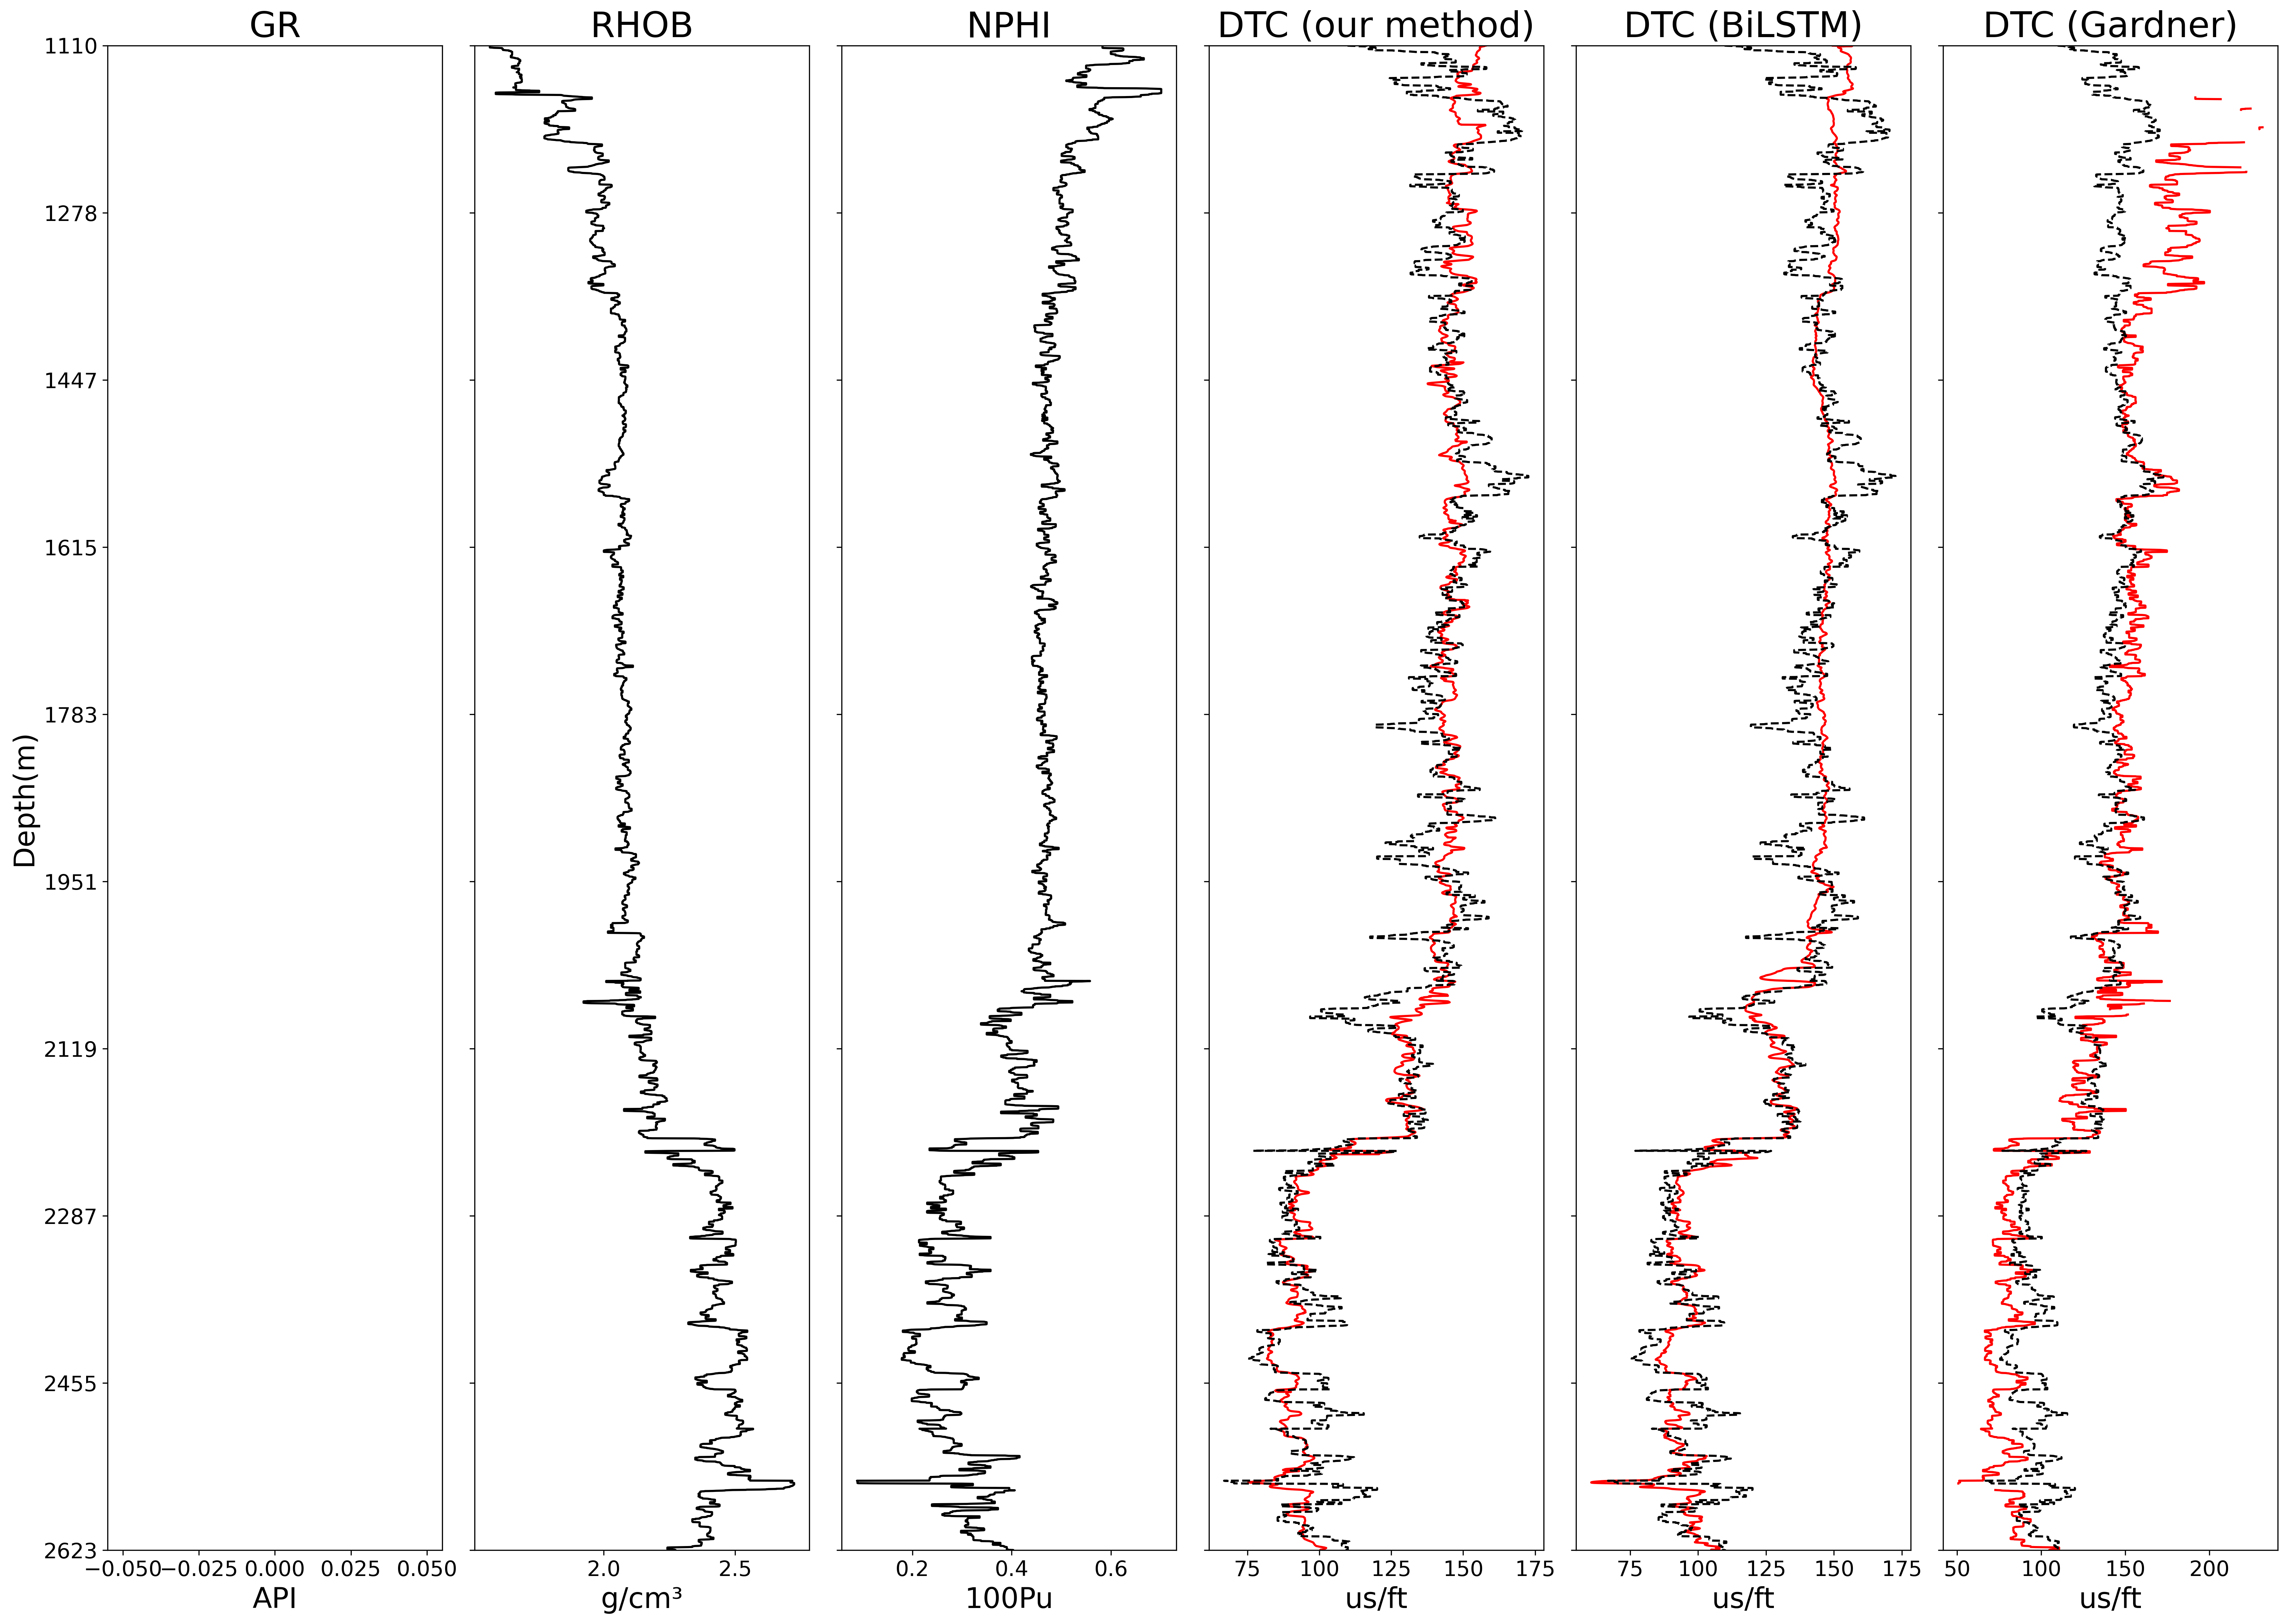

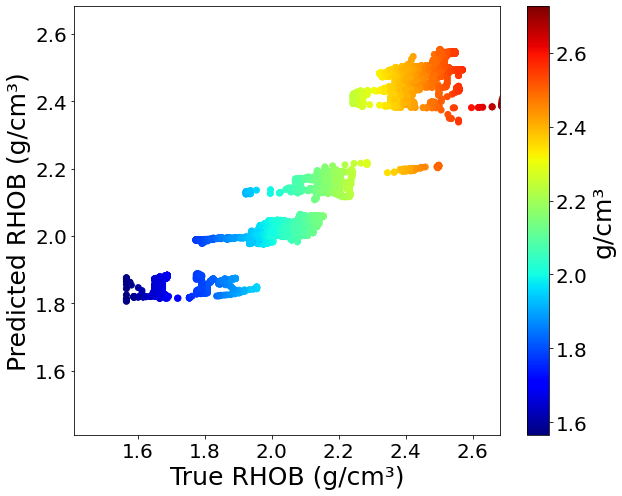

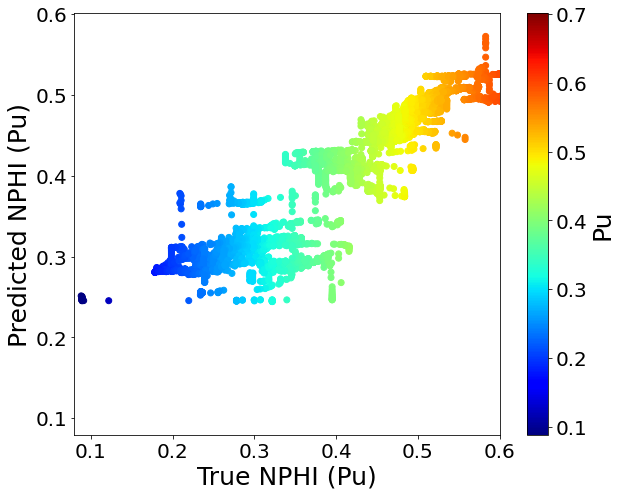

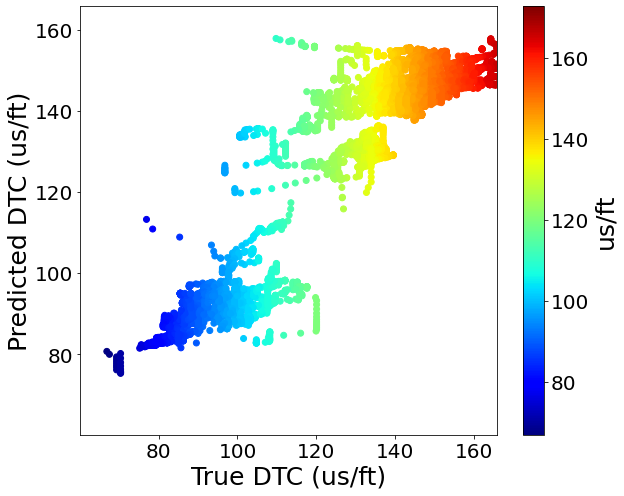

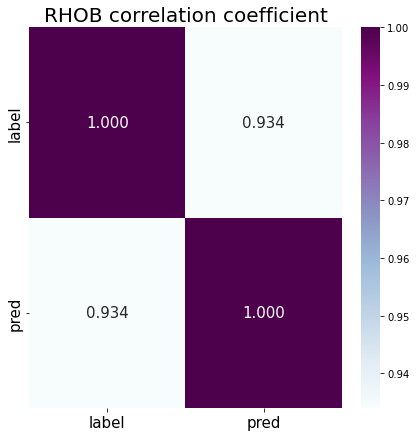

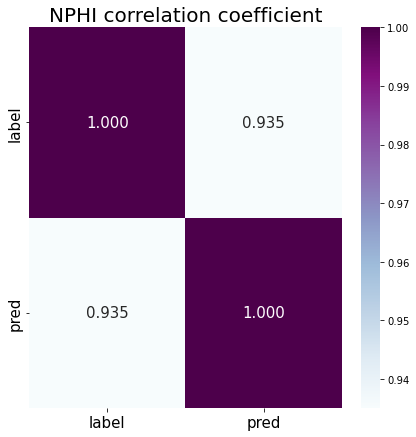

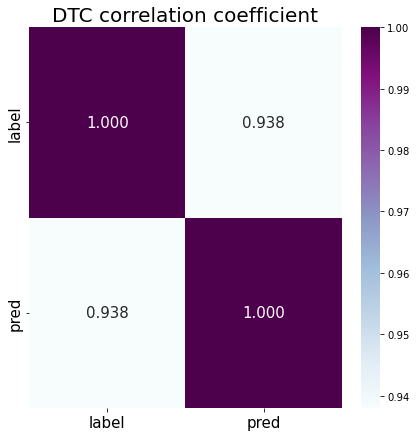

<Figure size 2400x4800 with 0 Axes>

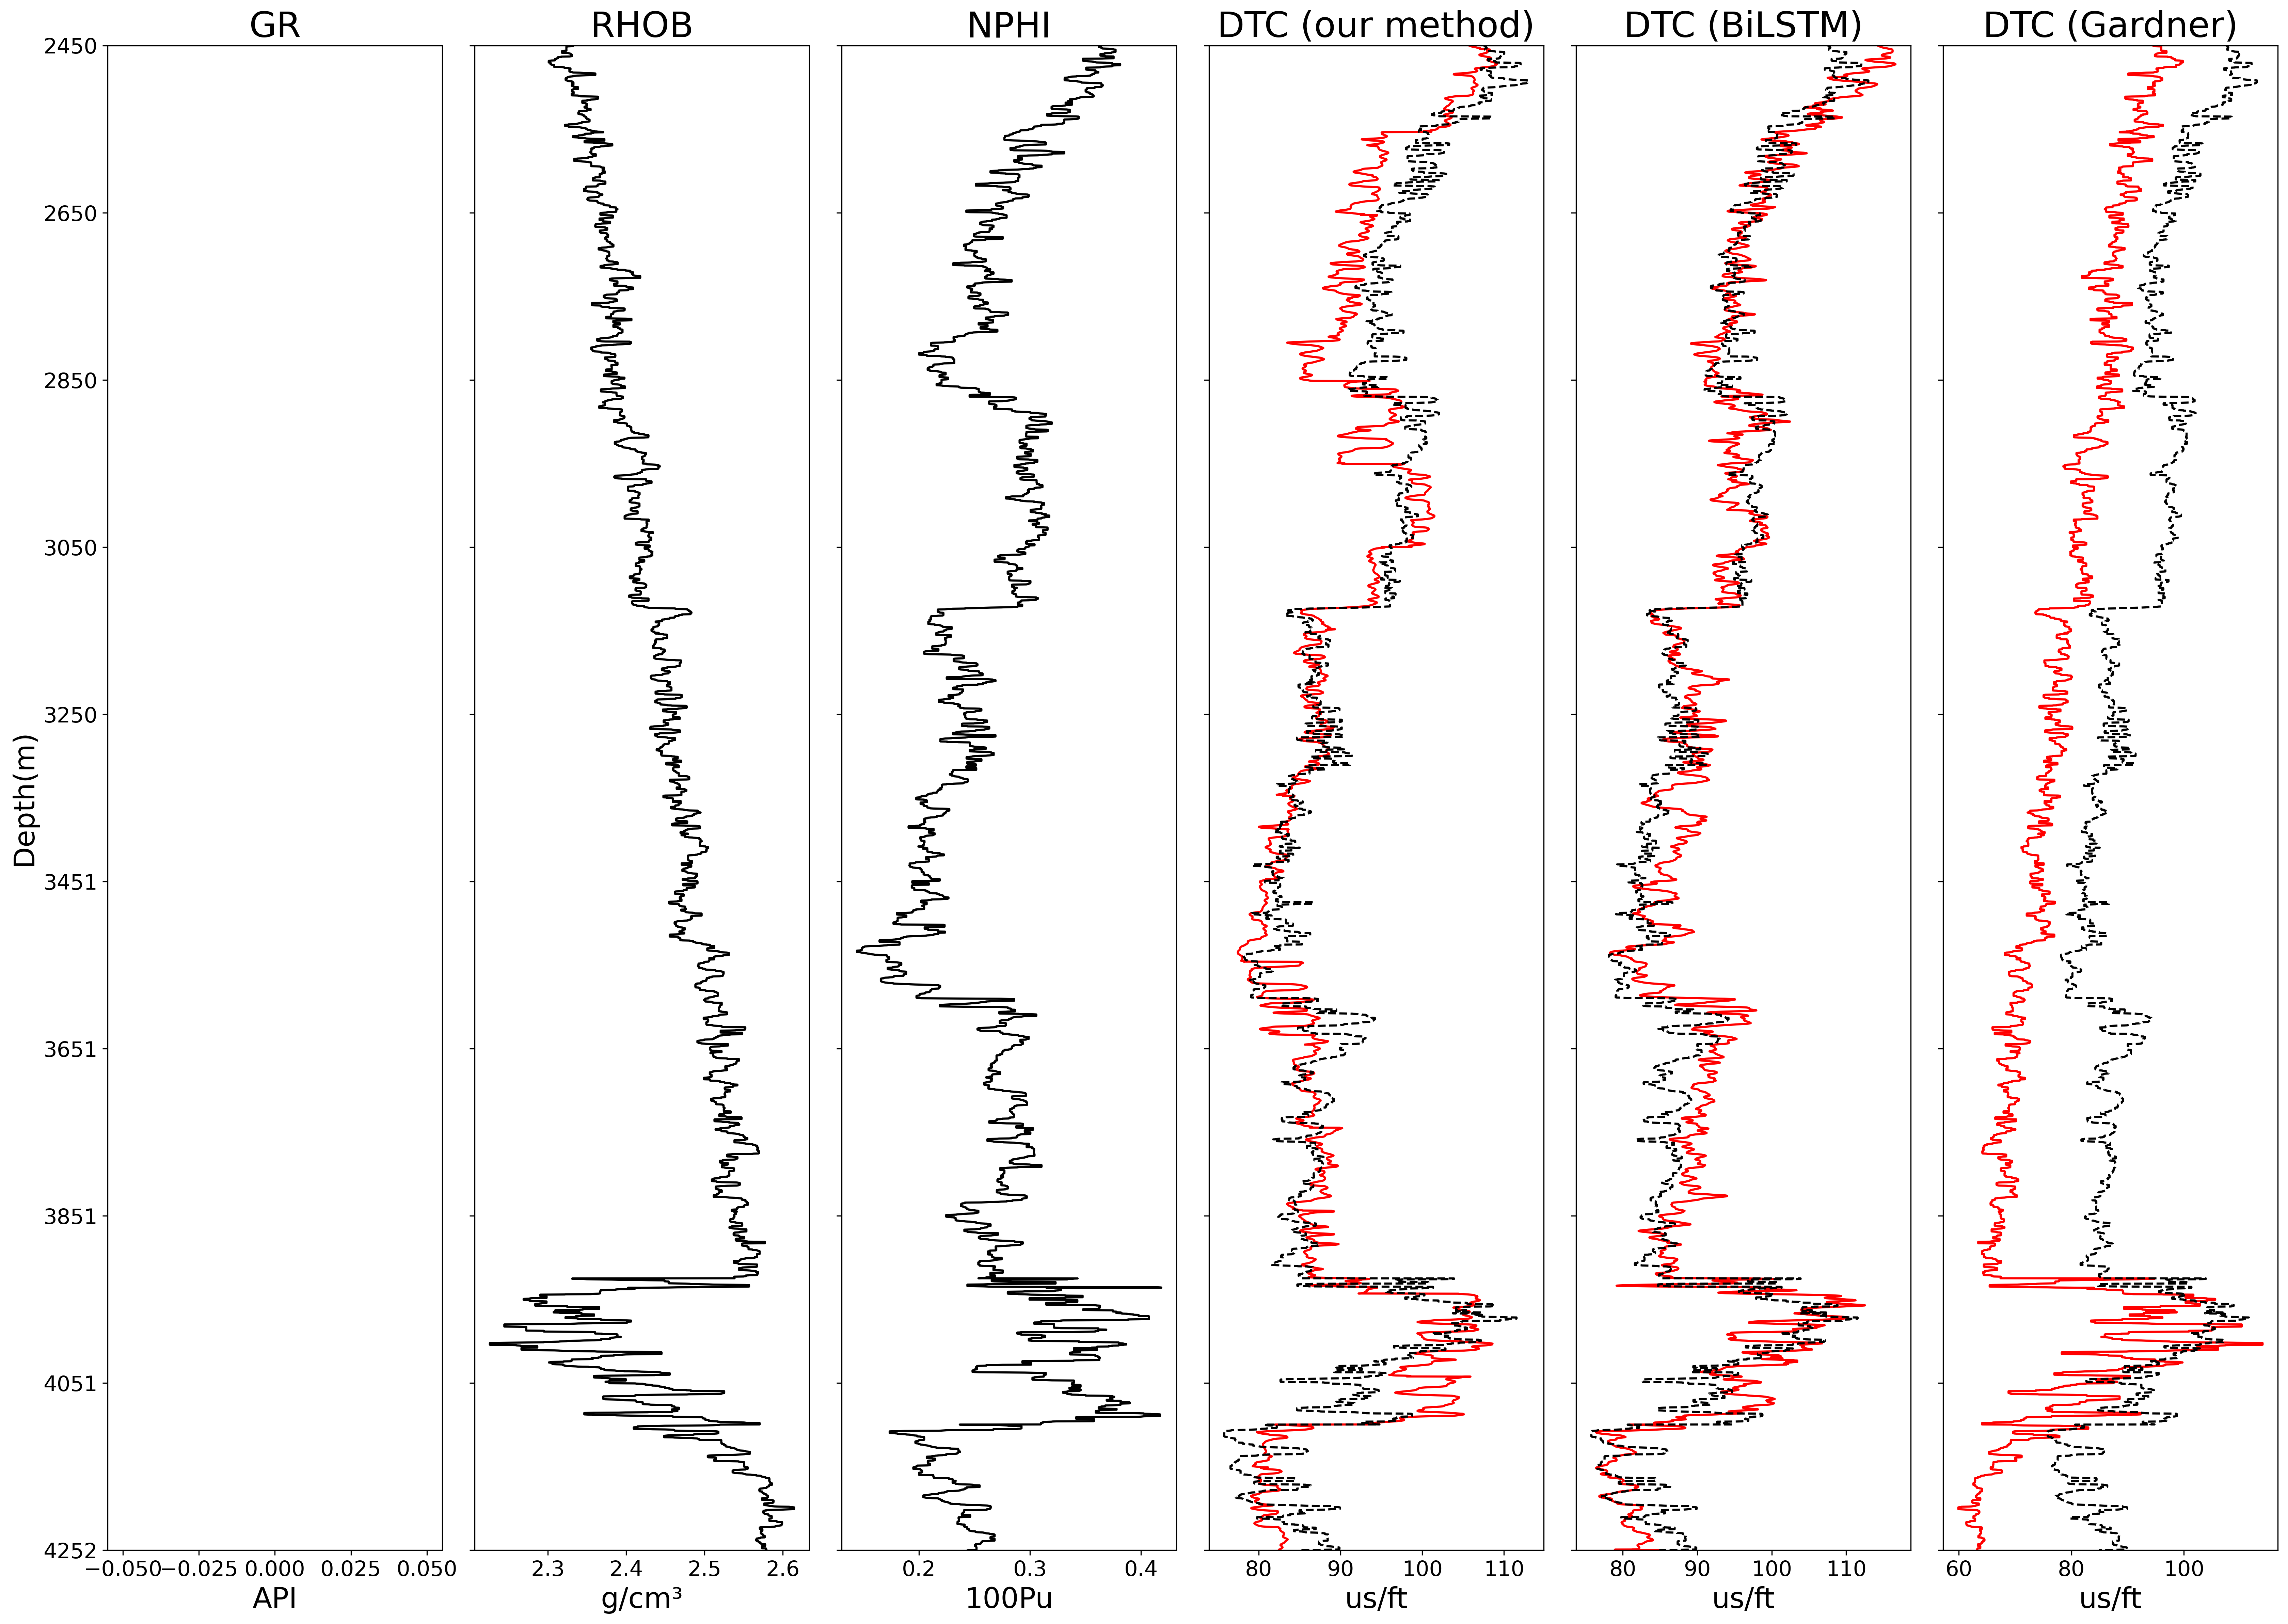

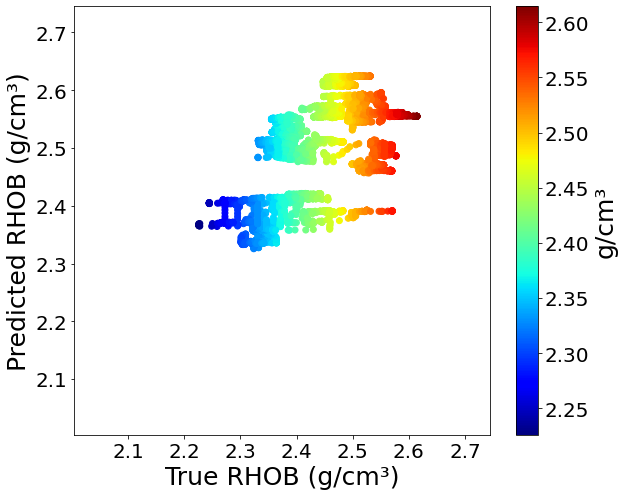

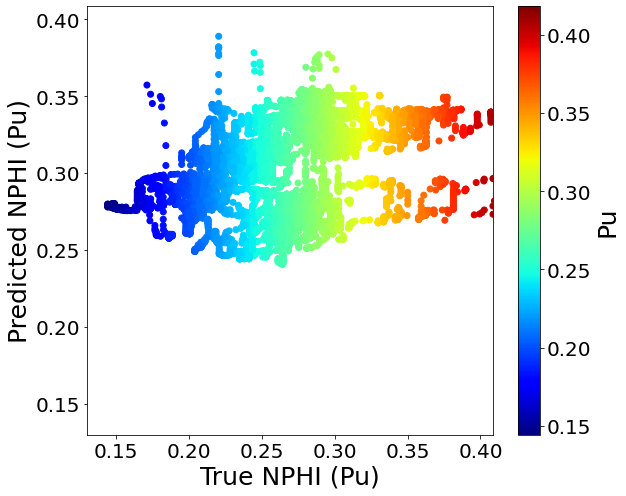

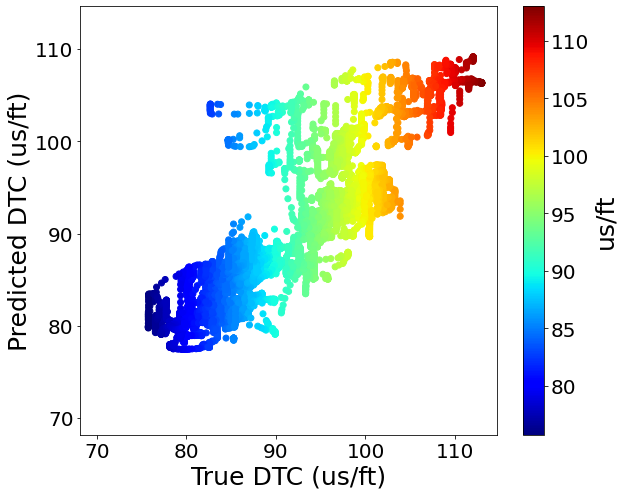

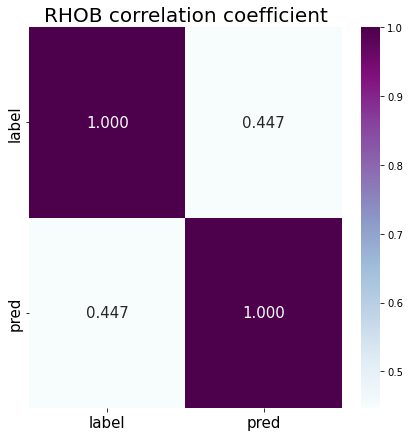

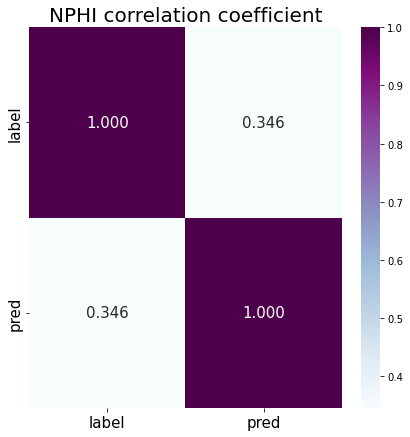

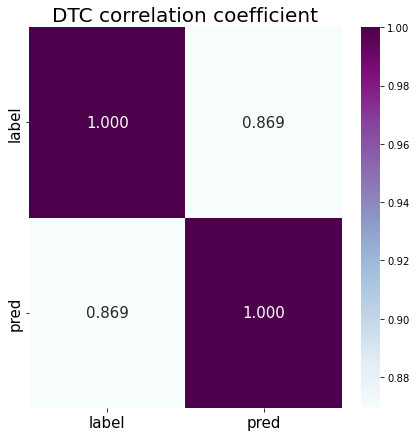

<Figure size 2400x4800 with 0 Axes>

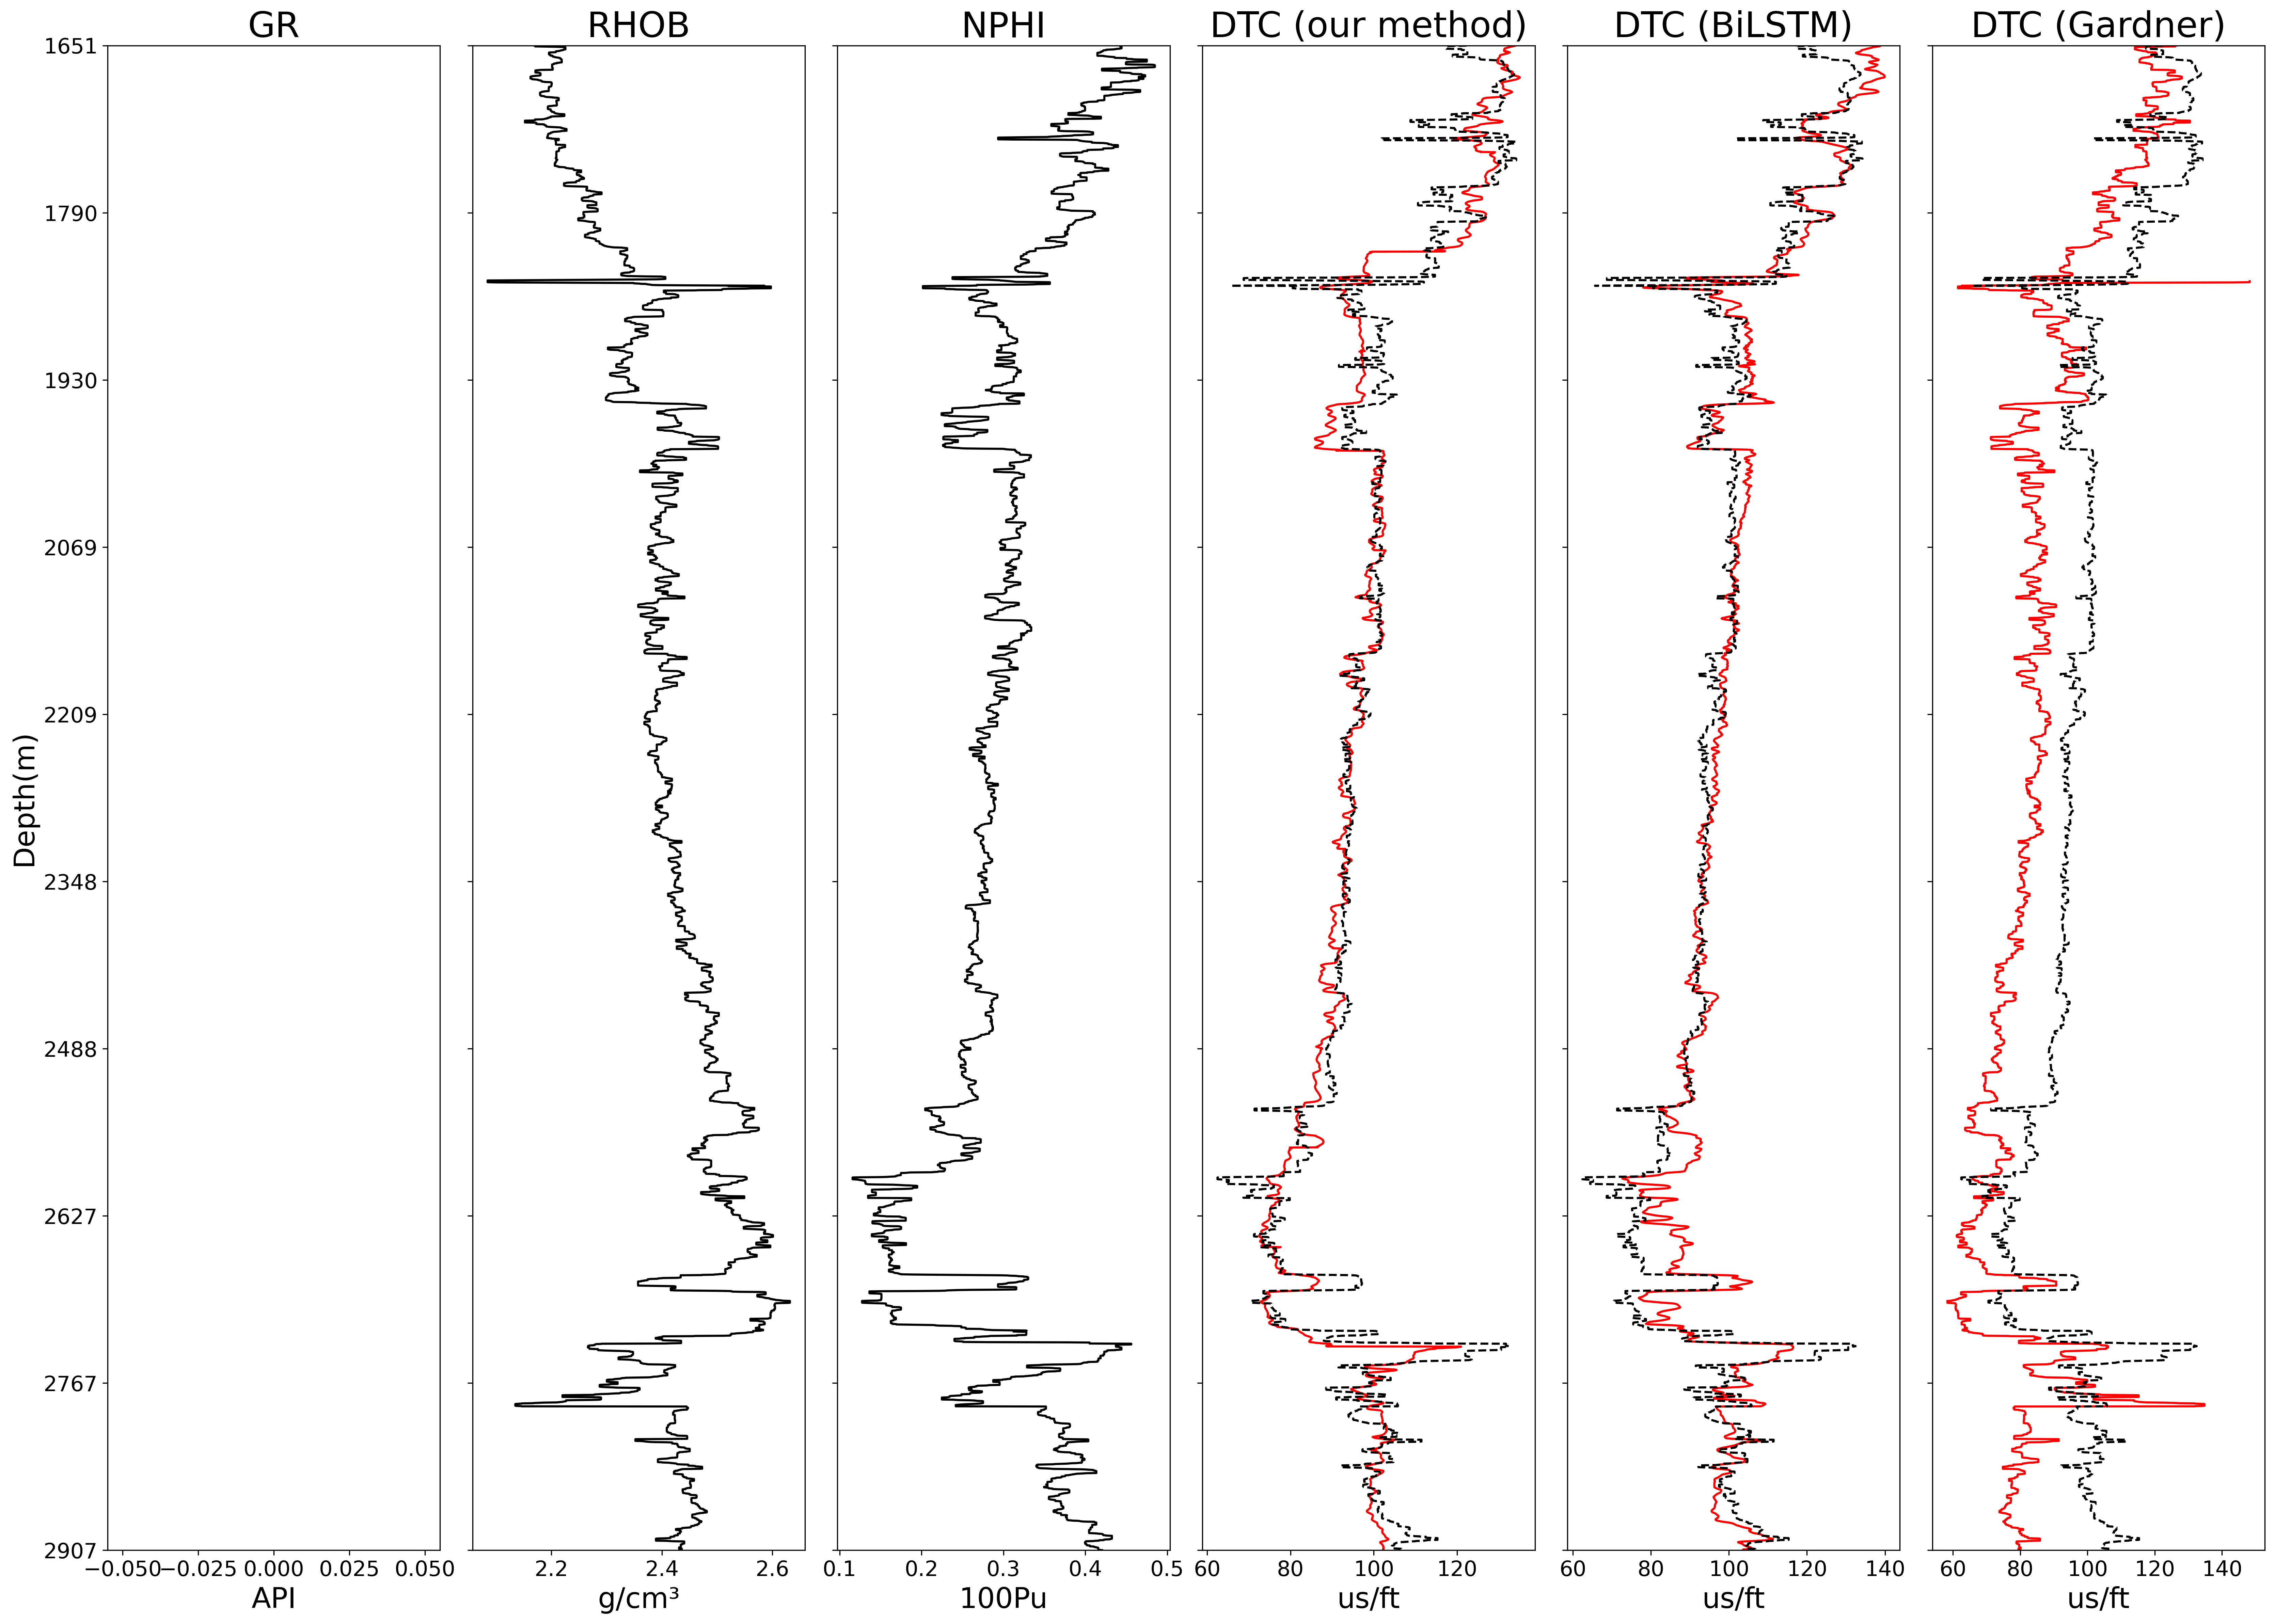

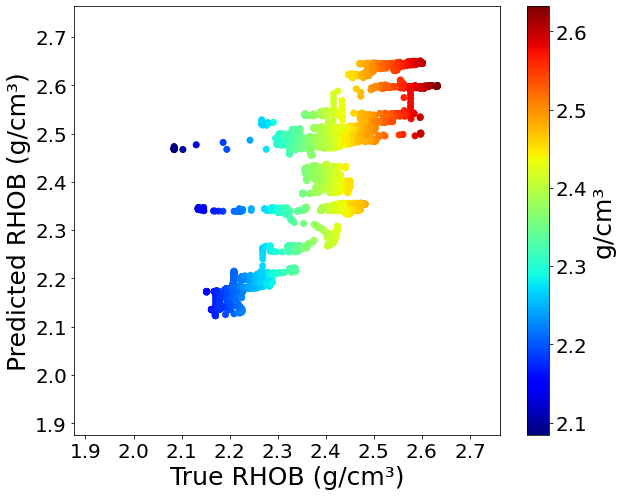

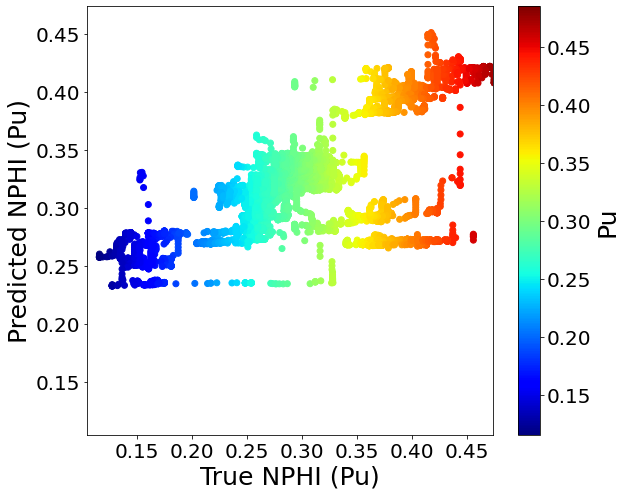

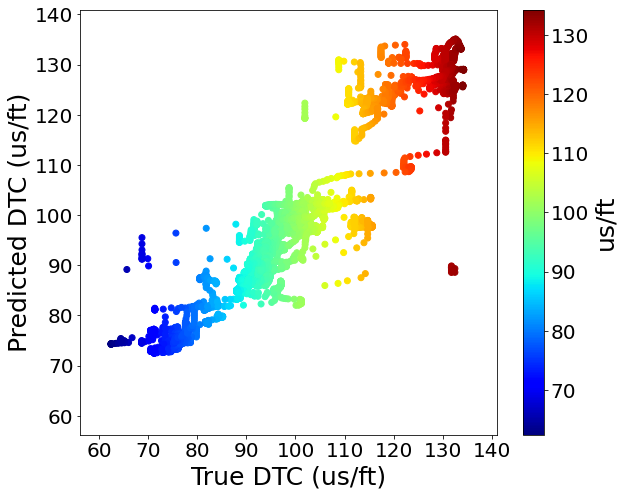

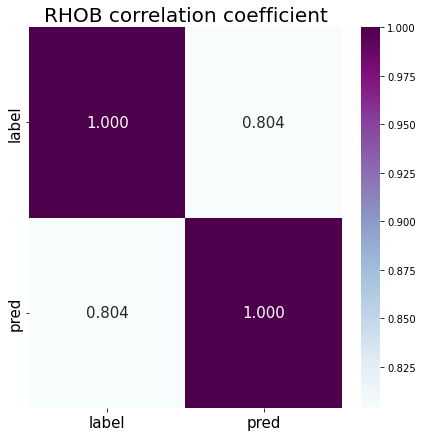

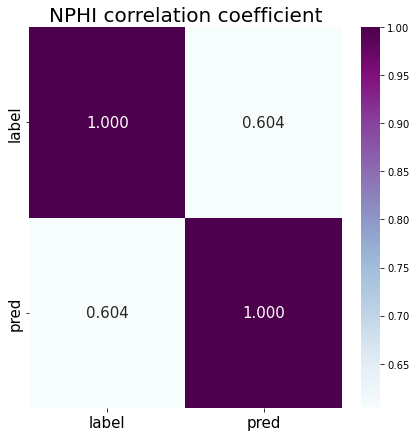

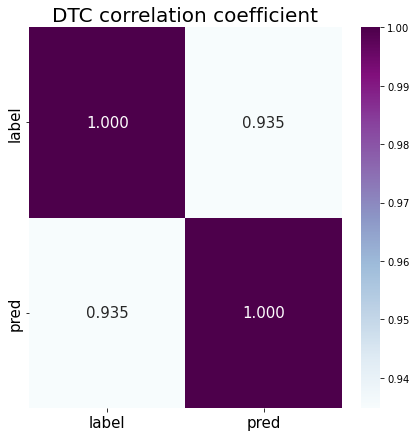

In [124]:
print('掩盖的log类型是：',param['mask_logs'])

well_MSE_list = []
LSTM_MSE_list = []
LSTM_corr_list = []

for wo in [2,7,9]:  ##
    #每口井中样本的个数 [21 22 19 33 21 17 15 23 42 20] all_well_name ['15/9-23' '16/2-7' '16/7-6' '17/4-1' '25/10-9' '31/2-10' '31/2-21 S' '34/3-2 S' '35/11-5' '35/9-7']
    #拼接取到的样本
    label = np.zeros((len(param['fea_litho']),param['sam_len']*num_siw[wo]))
    label_intact = np.zeros((len(param['fea_litho']),param['sam_len']*num_siw[wo]))
    input = np.zeros((len(param['fea_litho']),4,param['sam_len']*num_siw[wo]))  #4 表示4通道
    pred =  np.zeros((len(param['fea_litho']),param['sam_len']*num_siw[wo]))
    mask0 = np.zeros((len(param['fea_litho']),param['sam_len']*num_siw[wo]))
    maskd = np.zeros((len(param['fea_litho']),param['sam_len']*num_siw[wo]))

    for so in range(num_siw[wo]):  #so is sam order 表示可取到的样本在井中序号
        #print('so',so)
        if param['dataset_for_result'] == 'train':
            #print('用train数据集来看多个样本效果')
            fix_stap = so*param['sam_len']
            #print('fix_stap',fix_stap)
            wep = param['sam_len']*num_siw[wo]-1  #减去1是因为取不到最后一个 #wep=well_end_point
            #print('wep',wep)
            test_dataset = MyGNNDataset_cat_sam(dfTrain,param['sam_len'],param['sam_num'],param['fea_litho'],param['data_norm_type'],
                                                param['mask_logs'],param['null_sequence'],param['sam_fixed'],param['filt_size'],
                                                wo,wep,fix_stap)
        if param['dataset_for_result'] == 'val':
            print('用val数据集来看多个样本效果')
            fix_stap = so*param['sam_len']
            #print('fix_stap',fix_stap)
            wep = param['sam_len']*num_siw[wo]-1  #减去1是因为取不到最后一个 #wep=well_end_point
            #print('wep',wep)
            test_dataset = MyGNNDataset_cat_sam(dfval,param['sam_len'],param['sam_num'],param['fea_litho'],param['data_norm_type'],
                                                param['mask_logs'],param['null_sequence'],param['sam_fixed'],param['filt_size'],
                                                wo,wep,fix_stap)
        if param['dataset_for_result'] == 'test':
            #print('用test数据集来看多个样本效果')
            fix_stap = so*param['sam_len']
            #print('fix_stap',fix_stap)
            wep = param['sam_len']*num_siw[wo]-1  #减去1是因为取不到最后一个 #wep=well_end_point
            #print('wep',wep)
            test_dataset = MyGNNDataset_cat_sam(dfTest,param['sam_len'],param['sam_num'],param['fea_litho'],param['data_norm_type'],
                                                param['mask_logs'],param['null_sequence'],param['sam_fixed'],param['filt_size'],
                                                wo,wep,fix_stap)
            #param['sam_len'],fix_stap
        test_loader = loader.DataLoader(test_dataset, batch_size=param['batch_size'],num_workers=1)
        '''上述test_dataset和test_loader用到了MyGNNDataset_test_whole_well、DataLoader，但这里只是定义初始化好，
        并没有实际生成数据样本，而是到了下面for data in test_loader_n中调用data时，才开始实际生成数据来调用'''

        if param['label_intact'] == True:  #当用测试集里完整的label时，==True，运行这里
            predictions, labels, inputdatas, mask0s, maskds, label_intacts, md_staps,md_endps = prediction_label_input(test_loader)
            label_intact[:,param['sam_len']*so:param['sam_len']*(so+1)] = label_intacts[0]
            
        else: 
            predictions, labels, inputdatas, mask0s, maskds, md_staps,md_endps = prediction_label_input(test_loader)
        
        label[:,param['sam_len']*so:param['sam_len']*(so+1)] = labels[0]
        pred[:,param['sam_len']*so:param['sam_len']*(so+1)] = predictions[0]
        input[:,:,param['sam_len']*so:param['sam_len']*(so+1)] = inputdatas[0]
            
        mask0[:,param['sam_len']*so:param['sam_len']*(so+1)] = mask0s[0]      #不要搞糊涂了，mask0和maskd是不能*stds[0]+means[0]！！！
        maskd[:,param['sam_len']*so:param['sam_len']*(so+1)] = maskds[0]
    

    """画在一起  MSE可以单独算再比对"""
    ###读取数据
    path = '/home/cldai/sciresearch/logcomplete/data/pred/原测试集10口盲井/'
    bip = pd.read_csv(path+'bilstm_'+str(param['mask_logs'][0])+
                      '/'+all_well_name_r[wo]+'_pred.csv')
    #print('读取的bilstm的预测', bip)
    bip_np = np.array(bip)
    bip_np = bip_np.T


    ####暂时放在这用于实验，后面删掉
    labelz = label.copy()
    predz = pred.copy()
    inputz = input.copy()
    mask0z = mask0.copy()
    maskdz = maskd.copy()
    label_intactz = label_intact.copy() 
    bip_npz = bip_np.copy()
    
    '''下面算是后处理，截掉部分数据，使画图和coef计算共有深度段的'''
    if wo==0:    
        print('######  15_9-23井裁剪  ##########')
        lsta = 50
        label = labelz[:, lsta:]
        pred = predz[:, lsta:]
        input = inputz[:,:, lsta:]
        mask0 = mask0z[:, lsta:]
        maskd = maskdz[:, lsta:]
        label_intact = label_intactz[:, lsta:]
        bip_np = bip_npz[:, lsta:]
        md_staps[:,:] = 1526
        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)

    if wo==1:    
        print('######  16_2-7井裁剪  ##########')
        lq = 30
        lth = 8700  #
        labelq = labelz[:,lq:lth]
        predq = predz[:,lq:lth]
        inputq = inputz[:,:,lq:lth]
        mask0q = mask0z[:,lq:lth]
        maskdq = maskdz[:,lq:lth]
        label_intactq = label_intactz[:,lq:lth]
        bip_npq = bip_npz[:, lq:lth]

        hou=9250   #
        labelh = labelz[:,hou:]
        predh = predz[:,hou:]
        inputh = inputz[:,:,hou:]
        mask0h = mask0z[:,hou:]
        maskdh = maskdz[:,hou:]
        label_intacth = label_intactz[:,hou:]
        bip_nph = bip_npz[:, hou:]


        label = np.hstack((labelq, labelh))
        pred = np.hstack((predq, predh))
        input = np.concatenate((inputq, inputh),axis=2)
        mask0 = np.hstack((mask0q, mask0h))
        maskd = np.hstack((maskdq, maskdh))
        label_intact = np.hstack((label_intactq, label_intacth))
        bip_np = np.hstack((bip_npq, bip_nph))

        print('删减长度后input的shape, label.shape', input.shape, label.shape)

        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)


    if wo==3:    
        print('######  17_4-1井裁剪  ##########')
        lsta = 4500
        lth = 11000
        label = labelz[:, lsta:lth]
        pred = predz[:, lsta:lth]
        input = inputz[:,:, lsta:lth]
        mask0 = mask0z[:, lsta:lth]
        maskd = maskdz[:, lsta:lth]
        label_intact = label_intactz[:, lsta:lth]
        bip_np = bip_npz[:, lsta:lth]
        md_staps[:,:] = 1800
        md_endps[:,:] = 2830
        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)

    if wo==4:    
        print('######  25_20-9井裁剪  ##########')
        lq = 80
        lth = 7450  #
        labelq = labelz[:,lq:lth]
        predq = predz[:,lq:lth]
        inputq = inputz[:,:,lq:lth]
        mask0q = mask0z[:,lq:lth]
        maskdq = maskdz[:,lq:lth]
        label_intactq = label_intactz[:,lq:lth]
        bip_npq = bip_npz[:, lq:lth]

        hou=7550   #
        labelh = labelz[:,hou:]
        predh = predz[:,hou:]
        inputh = inputz[:,:,hou:]
        mask0h = mask0z[:,hou:]
        maskdh = maskdz[:,hou:]
        label_intacth = label_intactz[:,hou:]
        bip_nph = bip_npz[:, hou:]

        label = np.hstack((labelq, labelh))
        pred = np.hstack((predq, predh))
        input = np.concatenate((inputq, inputh),axis=2)
        mask0 = np.hstack((mask0q, mask0h))
        maskd = np.hstack((maskdq, maskdh))
        label_intact = np.hstack((label_intactq, label_intacth))
        bip_np = np.hstack((bip_npq, bip_nph))
        print('删减长度后input的shape, label.shape', input.shape, label.shape)


        # md_staps[:,:] = 2450
        # md_endps[:,:] = 4252
        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)

    if wo==7:    
        print('######  34_3-2井裁剪  ##########')
        lq = 490
        lth = 9000  #9100  9200 9000 
        labelq = labelz[:,lq:lth]
        predq = predz[:,lq:lth]
        inputq = inputz[:,:,lq:lth]
        mask0q = mask0z[:,lq:lth]
        maskdq = maskdz[:,lq:lth]
        label_intactq = label_intactz[:,lq:lth]
        bip_npq = bip_npz[:, lq:lth]

        hou=11000   #9700   11264
        labelh = labelz[:,hou:]
        predh = predz[:,hou:]
        inputh = inputz[:,:,hou:]
        mask0h = mask0z[:,hou:]
        maskdh = maskdz[:,hou:]
        label_intacth = label_intactz[:,hou:]
        bip_nph = bip_npz[:, hou:]

        label = np.hstack((labelq, labelh))
        pred = np.hstack((predq, predh))
        input = np.concatenate((inputq, inputh),axis=2)
        mask0 = np.hstack((mask0q, mask0h))
        maskd = np.hstack((maskdq, maskdh))
        label_intact = np.hstack((label_intactq, label_intacth))
        bip_np = np.hstack((bip_npq, bip_nph))
        print('删减长度后input的shape, label.shape', input.shape, label.shape)

        md_staps[:,:] = 2450
        md_endps[:,:] = 4252
        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)

    if wo==8:    
        print('######  34_11-5井裁剪  ##########')
        lth = 14500   #3750为减去DTC和RHOB上面缺失的一小部分， 14500为减去NPHI上面部分
        label = labelz[:,lth:]
        pred = predz[:,lth:]
        input = inputz[:,:,lth:]
        mask0 = mask0z[:,lth:]
        maskd = maskdz[:,lth:]
        label_intact = label_intactz[:,lth:]
        bip_np = bip_npz[:, lth:]

        md_staps[:,:] = 995
        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)

    if wo==9:    
        print('######  35_9-7井裁剪  ##########')
        lq = 1500
        lth = 8500  #9100  9200 9000 
        labelq = labelz[:,lq:lth]
        predq = predz[:,lq:lth]
        inputq = inputz[:,:,lq:lth]
        mask0q = mask0z[:,lq:lth]
        maskdq = maskdz[:,lq:lth]
        label_intactq = label_intactz[:,lq:lth]
        bip_npq = bip_npz[:, lq:lth]

        hou=9500   #
        labelh = labelz[:,hou:]
        predh = predz[:,hou:]
        inputh = inputz[:,:,hou:]
        mask0h = mask0z[:,hou:]
        maskdh = maskdz[:,hou:]
        label_intacth = label_intactz[:,hou:]
        bip_nph = bip_npz[:, hou:]

        label = np.hstack((labelq, labelh))
        pred = np.hstack((predq, predh))
        input = np.concatenate((inputq, inputh),axis=2)
        mask0 = np.hstack((mask0q, mask0h))
        maskd = np.hstack((maskdq, maskdh))
        label_intact = np.hstack((label_intactq, label_intacth))
        bip_np = np.hstack((bip_npq, bip_nph))
        print('删减长度后input的shape, label.shape', input.shape, label.shape)

        md_staps[:,:] = 1651
        md_endps[:,:] = 2907
        print('深度的shape', md_endps.shape, md_endps)
        print('标签，输入的shape', label.shape, input.shape)



    print('画{}井'.format(all_well_name_r[wo]))
    if param['plot_figure']==True:

        if param['multi_ch'] == True:
            #由于是多通道，经过列表append后，input的shape为(1, 4, 4, 512)
            #print('查看输入的原始第一通道数据',input[:,0,:])
            if param['label_intact']==True:
                #print('input[:,0,:]',input[:,0,:],'pred',pred,'label_intact',label_intact)
                #画log输入及预测结果
    #                 plt_cat_sam(input[:,0,:],pred,label_intact,mask0,maskd,
    #                             param['fea_litho'],md_staps[0],md_endps[0],param['fig_path'],
    #                             all_well_name_r[wo],param['label_intact'],param['pnl'])
               
                # #画paper中阐述工作的图(以32-2-10阐述)
                # plt_state_work(label_intact,param['fig_path'])


                paper_plt_cat_sam(input[:,0,:],pred,label_intact,mask0,maskd,param['fea_litho'],md_staps[0],
                                  md_endps[0],param['fig_path'],all_well_name_r[wo],param['label_intact'],
                                  param['pnl'],param['mask_logs'][0],param['plot_Gardner'],
                                  
                                  bilstm_pred=bip_np)

                #计算相关系数,并绘制散点图
                whole_well_corr(pred,label_intact,param['fea_litho'],param['fig_path'],all_well_name_r[wo])

                ##计算MSE定量评价指标
                eva = calculate_MSE(pred,label_intact,param['fea_litho'], param['mask_logs'][0])
                well_MSE_list.append(eva)


                # #看Gardner方程的预测效果以及计算相关系数，并计算MSE
                # whole_gardner(label_intact,param['fea_litho'],md_staps[0],md_endps[0],param['fig_path'],
                #               all_well_name_r[wo])

                
                ##下面计算clip后的BiLSTM效果的MSE和相关系数
                ##mse
                lstm_mse = calculate_MSE(bip_np,label_intact,param['fea_litho'], 
                                         param['mask_logs'][0], bilstm=True)
                LSTM_MSE_list.append(lstm_mse)
                ##corr
                bilstm_corr = bilstm_well_corr(bip_np,label_intact,param['fea_litho'], 
                                         param['mask_logs'][0])
                LSTM_corr_list.append(bilstm_corr)



well_name = pd.DataFrame(all_well_name_r,columns=['well_name'])
MSE_eva = pd.DataFrame(well_MSE_list,columns=['GNN'])
bilstm_mse = pd.DataFrame(LSTM_MSE_list,columns=['BiLSTM'])
#print('MSE_eva.shape', MSE_eva.shape)
df_well_MSE = pd.concat([well_name, MSE_eva, bilstm_mse], axis=1) 
df_well_MSE.to_csv(path+'GNN_BiLSTM_MSE/'+str(param['mask_logs'][0])+'_clip'
                      +'.csv',
                   index=False, float_format="%.5f")
print("df_well_RMSE", df_well_MSE)

print('LSTM_corr_list', LSTM_corr_list)
